# Introduction to polynomial regression

Let's start my first importing the pypce library and any third party libraries we might need like numpy or matplotlib. 

## Setup the problem

In [1]:
import pypce
import numpy as np
import matplotlib.pyplot as mpl

Now, let's generate some two-dimensional multivariate data to show how pypce works!

In [2]:
rn = np.random.RandomState(123)
X = 2*rn.rand(100,2)-1
y = X[:,0] + .5*(3*X[:,1]**2-1) 
print(X.shape,y.shape)

(100, 2) (100,)


This generate a data matrix $X$ of size (nsamples,dim) and labeled data $y$ of shape (nsamples,). We can plot the univariate data using matplotlib. 

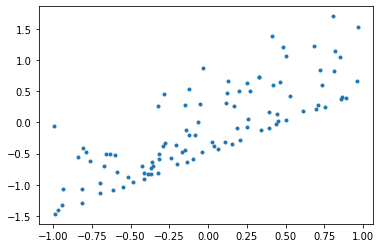

In [3]:
mpl.plot(X[:,0],y,'.')

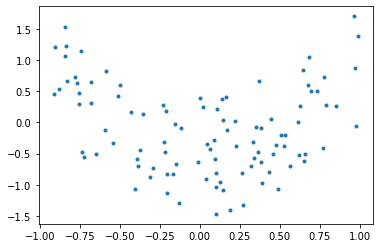

In [4]:
mpl.plot(X[:,1],y,'.')

Note that the $x_1$ dependence on $y$ is more linear, whereas the $x_2$ dependence is quadratic, which is done by construction. Let's keep this in mind so that we can make sure the polynomial fit we obtain reflects this relation. 

## Fit a polynomial

Now let's fit the polynomial. To do this we need to initialize the PCE regression class. To do this, we need to define the order of the polynomial we want to fit and the fit algorithm. These two common parameters are referred to as hyper-parameters. We can optimize over them later using the grid search methods in sklearn. For now, let us choose a second order polynomial and a least squares fit algorithm. 

In [5]:
pce = pypce.PCEReg(order=2,fit_type='linear')

Initialization is fast since no computation or basis construction has been done. It is when we fit the polynomial that the basis construction takes place. So let's fit the polynomial!

In [20]:
pce.fit(X,y)

PCEReg(coef=array([-0.        ,  0.99913597, -0.        ,  0.        , -0.        ,
        0.99834676]),
       fit_params={'l1_ratio': [0.001, 0.5, 0.75, 0.95, 0.999, 1],
                   'n_alphas': 25, 'tol': 0.01},
       fit_type='ElasticNetCV')

This returns the object back and displays the coefficient vector. For all intents and purposes, a user does not need to know what the coefficients are, but for purposes of this tutorial, let us take a look so that we can verify that the fit is correct. 

In [7]:
print("c=\n",pce.coef)
print("multi-index:\n",pce.mindex)

c=
 [ 3.68829304e-17  1.00000000e+00 -1.11022302e-15  4.44089210e-16
 -1.11022302e-16  1.00000000e+00]
multi-index:
 [[0 0]
 [1 0]
 [0 1]
 [2 0]
 [1 1]
 [0 2]]


Notice that coefficient array contains all zeros (essentially) except for the second and last entries. This is actually by design! We defined the function $y$ to be a simple sum of the first order Legendre polynomial in $x_1$ and the second order Legendre polynomial in $x_2$. And if we look at the multi-index array, which represents the components of each basis function, the second and last row correspond to these exact polynomial terms. To be explicit, the multi-index row $[p,q]$ represents the basis corresponding to the product of the $p^{th}$ order polynomial in $x_1$ and the $q^{th}$ order polynomial in $x_2$. 

Two final points before we move on. The linear fit algorithm worked perfectly well since our data was not corrupted by noise. When noise becomes a problem, or we expect outliers, it is probably better to use the LassoCV or ElasticNetCV algorithms. The good news is that we have wrappers that allow the user to perform a simple hyper-parameter search to figure out the best fit. To show that a fit with regression would not work well for this case, look at the following. 

In [8]:
pce_lasso = pypce.PCEReg(order=2,fit_type='LassoCV')
pce_lasso.fit(X,y)

PCEReg(coef=array([-4.23429475e-04,  1.00037195e+00,  2.12998050e-04, -3.61174005e-04,
       -5.52452618e-04,  9.99757827e-01]),
       fit_params={'alphas': array([1.00000000e-12, 3.83118685e-12, 1.46779927e-11, 5.62341325e-11,
       2.15443469e-10, 8.25404185e-10, 3.16227766e-09, 1.21152766e-08,
       4.64158883e-08, 1.77827941e-07, 6.81292069e-07, 2.61015722e-06,
       1.00000000e-05, 3.83118685e-05, 1.46779927e-04, 5.62341325e-04,
       2.15443469e-03, 8.25404185e-03, 3.16227766e-02, 1.21152766e-01,
       4.64158883e-01, 1.77827941e+00, 6.81292069e+00, 2.61015722e+01,
       1.00000000e+02]),
                   'max_iter': 1000, 'tol': 0.01},
       fit_type='LassoCV')

The coefficient array in this case is over regularized but it's not bad. This is because the LassoCV is allowed to find the best regularization parameter, which in this case it $0$. 

## Feature importance

Let's us now see how we can show the feature importances. For polynomials, we use the total order Sobol sensitivity indices. This is essentially a weighted average of the polynomial coefficients. This is one of the nice properties of using orthogonal polynomials. 

In [9]:
pce.feature_importances_

array([0.625, 0.375])

Sobol sensitivity indices essentially give us a metric for how much of the total variance is explained by each individual variance. So what this says is that $x_1$ is more importance to the variability of the output. This doesn't mean that $x_2$ doesn't matter. Note the syntax is similar to the random forest feature importance syntax in sklearn. 

## Prediction

Once the coefficient array is determined, typically by the fit function or (less commonly) by pre-defining the coefficient array in the constructor, we can make predictions. This is quite simple by using the ``predict`` class method. 

In [10]:
ypred = pce.predict(X)
print('MSE: {0:2E}, \nMPE: {1:3E}'.format(np.mean((ypred-y)**2), np.mean(100*(ypred-y)**2/y**2)))

MSE: 6.985656E-31, 
MPE: 3.553763E-26


We can see this in another way by plotting the prediction vs the truth. Ideally, the graph should align perfectly with a y=x line plot.

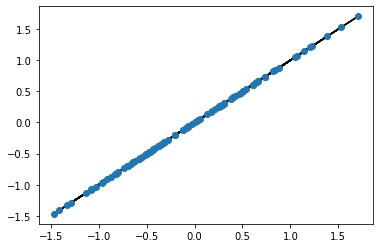

In [11]:
mpl.plot(y,y,'k',alpha=1,ms=2)
mpl.plot(y,ypred,'o')

### Scale error

We mentioned before that $X$ must be scaled to be over [-1,1] since the polynomials are defined on that range. Let's see what happens when we feed a polynomial outside that range. 

In [12]:
pce.fit(2*X,y)

AssertionError: range for X must be between -1 and 1 for now. scale inputs accordingly. 

Note that we will NOT get an error if X is defined on $[0,1]$. 

In [15]:
pce.fit(.5*(X+1),y)

PCEReg(coef=array([ 1.49367831,  1.77311607, -4.79944048,  0.16374152, -0.        ,
        3.24392684]),
       fit_params={'l1_ratio': [0.001, 0.5, 0.75, 0.95, 0.999, 1],
                   'n_alphas': 25, 'tol': 0.01},
       fit_type='ElasticNetCV')

In this case, the fit will not be what one expects since we expect the input to be on [-1,1]. So be careful!!

## Different fit algorithms

Now let's look at the accuracy of different fit algorithms. In this example, we will train and test on the same set, but in a formal setting, you should not do that (we will explore this in later tutorials).  

The different fit algorithms from sklearn are LassoCV, ElasticNetCV, OmpCV, and linear least squares. We will fit a polynomial for each one of these algorithms with and without noise to see how accurate they are. 


In [16]:
algs = ['linear', 'LassoCV', 'ElasticNetCV']
for alg in algs:
    pce = pypce.PCEReg(order=2,fit_type=alg)
    pce.fit(X,y)
    ypred = pce.predict(X)
    print("Error using {0}: {1:.3E}".format(alg,np.sum((ypred-y)**2)))

Error using linear: 6.986E-29
Error using LassoCV: 2.085E-05
Error using ElasticNetCV: 7.523E-05


They are all pretty good, but linear least squares gives the best fit. Now, let's try the same with noise! First, let us create an output corrupted by simple additive white noise

In [17]:
y_w_noise = y.copy() + .1*rn.randn(len(y))

In [18]:
algs = ['linear', 'LassoCV', 'ElasticNetCV']
for alg in algs:
    pce = pypce.PCEReg(order=2,fit_type=alg)
    pce.fit(X,y_w_noise)
    ypred = pce.predict(X)
    print("Error using {0}: {1:.3E}".format(alg,np.sum((ypred-y)**2)))

Error using linear: 4.601E-02
Error using LassoCV: 2.747E-02
Error using ElasticNetCV: 2.552E-02


This time, LassoCV or ElasticNetCV give the best solution!